<a href="https://colab.research.google.com/github/harshjha0304/lncRNA/blob/main/working_MTP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# conda env update --file environment.yml 

In [1]:
import torch
if torch.cuda.is_available():
   device = torch.device('cuda:0')
   print('CUDA is available. Using device:', device)
else:
      device = torch.device('cpu')
      print('CUDA is not available. Using CPU.')

CUDA is available. Using device: cuda:0


In [2]:
import torch
torch.__version__

'1.10.1'

In [3]:
!pip install torch-geometric


In [4]:
%pip install torch_scatter


Note: you may need to restart the kernel to use updated packages.


In [5]:
!pip install torch-sparse

**GITHUB CLONING**

In [6]:
!rm -rf /content/lncRNA

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [7]:
! git clone https://github.com/harshjha0304/lncRNA.git

Cloning into 'lncRNA'...


### **CODE**

In [8]:
import numpy as np
np.__version__

'1.21.2'

In [11]:
import time
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

import argparse

from torch.utils.data import DataLoader
from torch_geometric.data import Data
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, precision_score, recall_score, \
    f1_score, roc_curve, auc, precision_recall_curve
from torch_sparse import SparseTensor
from gcn import GCN_mgaev3 as GCN
from mgaev import SAGE_mgaev2 as SAGE
from gin import GIN_mgaev2 as GIN
from LPdecoder import LPDecoder
from build import VariationalGraphAutoEncoder
from utils import do_edge_split_direct, edgemask_um
from torch_geometric.utils import to_undirected, add_self_loops, negative_sampling




In [12]:
def draw_auc(y, pred):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='AUC = %0.4f' % roc_auc)
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('MNDR', fontsize=18)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

In [13]:
def draw_aupr(y, pred):
    average_precision = average_precision_score(y, pred)
    precision, recall, _ = precision_recall_curve(y, pred)
    plt.plot(recall, precision, label='AUPR = %0.4f' % average_precision)
    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precision', fontsize=16)
    plt.title('MNDR', fontsize=18)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

In [14]:
def tensor_to_numpy(tensor):
    # Converts PyTorch tensors to numpy arrays for metric computation
    return tensor.detach().cpu().numpy()

In [15]:
def evaluate_auc(train_pred, train_true, val_pred, val_true, test_pred, test_true, draw, threshold=0.85):
    # Convert tensors to numpy arrays for sklearn metrics
    train_pred_np = tensor_to_numpy(train_pred)
    val_pred_np = tensor_to_numpy(val_pred)
    test_pred_np = tensor_to_numpy(test_pred)
    train_true_np = tensor_to_numpy(train_true)
    val_true_np = tensor_to_numpy(val_true)
    test_true_np = tensor_to_numpy(test_true)

    # AUC
    train_auc = roc_auc_score(train_true_np, train_pred_np)
    valid_auc = roc_auc_score(val_true_np, val_pred_np)
    test_auc = roc_auc_score(test_true_np, test_pred_np)
    if draw:
        # draw_auc(test_true_np, test_pred_np)
        draw_aupr(test_true_np, test_pred_np)

    # Average Precision
    train_ap = average_precision_score(train_true_np, train_pred_np)
    valid_ap = average_precision_score(val_true_np, val_pred_np)
    test_ap = average_precision_score(test_true_np, test_pred_np)

    # Convert probabilities to binary predictions based on the threshold
    train_pred_binary = (train_pred > threshold).int()
    val_pred_binary = (val_pred > threshold).int()
    test_pred_binary = (test_pred > threshold).int()

    # Convert binary predictions to numpy for sklearn metrics
    train_pred_binary_np = tensor_to_numpy(train_pred_binary)
    val_pred_binary_np = tensor_to_numpy(val_pred_binary)
    test_pred_binary_np = tensor_to_numpy(test_pred_binary)

    # Accuracy
    train_accuracy = accuracy_score(train_true_np, train_pred_binary_np)
    valid_accuracy = accuracy_score(val_true_np, val_pred_binary_np)
    test_accuracy = accuracy_score(test_true_np, test_pred_binary_np)

    # Precision, Recall, and F1 Score (handling cases where there are no positive labels)
    train_precision = precision_score(train_true_np, train_pred_binary_np, zero_division=0)
    valid_precision = precision_score(val_true_np, val_pred_binary_np, zero_division=0)
    test_precision = precision_score(test_true_np, test_pred_binary_np, zero_division=0)

    train_recall = recall_score(train_true_np, train_pred_binary_np, zero_division=0)
    valid_recall = recall_score(val_true_np, val_pred_binary_np, zero_division=0)
    test_recall = recall_score(test_true_np, test_pred_binary_np, zero_division=0)

    train_f1 = f1_score(train_true_np, train_pred_binary_np, zero_division=0)
    valid_f1 = f1_score(val_true_np, val_pred_binary_np, zero_division=0)
    test_f1 = f1_score(test_true_np, test_pred_binary_np, zero_division=0)

    # Compile results
    results = {
        'AUC': (train_auc, valid_auc, test_auc),
        'AP': (train_ap, valid_ap, test_ap),
        'Accuracy': (train_accuracy, valid_accuracy, test_accuracy),
        'Precision': (train_precision, valid_precision, test_precision),
        'Recall': (train_recall, valid_recall, test_recall),
        'F1': (train_f1, valid_f1, test_f1)
    }

    return results

In [16]:
def train(model, predictor, data, split_edge, optimizer, args):
    model.train()
    predictor.train()

    adj, edge_index, edge_index_mask = edgemask_um(args.mask_ratio, split_edge, data.x.device, data.num_nodes)
    pre_edge_index = adj.to(data.x.device)
    pos_train_edge = edge_index_mask

    optimizer.zero_grad()
    h = model(data.x, pre_edge_index)
    edge = pos_train_edge
    pos_out = predictor(h, edge)
    pos_loss = -torch.log(pos_out + 1e-15).mean()

    new_edge_index, _ = add_self_loops(edge_index.cpu())
    edge = negative_sampling(
        new_edge_index, num_nodes=data.num_nodes,
        num_neg_samples=pos_train_edge.shape[1])

    edge = edge.to(data.x.device)

    neg_out = predictor(h, edge)
    neg_loss = -torch.log(1 - neg_out + 1e-15).mean()

    loss = pos_loss + neg_loss
    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    torch.nn.utils.clip_grad_norm_(predictor.parameters(), 1.0)

    optimizer.step()

    return loss.item()

In [19]:
@torch.no_grad()
def test(model, predictor, data, adj, split_edge, batch_size, draw=False):
    model.eval()
    h = model(data.x, adj)

    pos_train_edge = split_edge['train']['edge'].to(data.x.device)
    neg_train_edge = split_edge['train']['edge_neg'].to(data.x.device)
    pos_valid_edge = split_edge['valid']['edge'].to(data.x.device)
    neg_valid_edge = split_edge['valid']['edge_neg'].to(data.x.device)
    pos_test_edge = split_edge['test']['edge'].to(data.x.device)
    neg_test_edge = split_edge['test']['edge_neg'].to(data.x.device)

    pos_train_preds = []
    for perm in DataLoader(range(pos_train_edge.size(0)), batch_size):
        edge = pos_train_edge[perm].t()
        pos_train_preds += [predictor(h, edge).squeeze().cpu()]
    pos_train_pred = torch.cat(pos_train_preds, dim=0)

    pos_valid_preds = []
    for perm in DataLoader(range(pos_valid_edge.size(0)), batch_size):
        edge = pos_valid_edge[perm].t()
        pos_valid_preds += [predictor(h, edge).squeeze().cpu()]
    pos_valid_pred = torch.cat(pos_valid_preds, dim=0)

    neg_train_preds = []
    for perm in DataLoader(range(neg_train_edge.size(0)), batch_size):
        edge = neg_train_edge[perm].t()
        neg_train_preds += [predictor(h, edge).squeeze().cpu()]
    neg_train_pred = torch.cat(neg_train_preds, dim=0)

    neg_valid_preds = []
    for perm in DataLoader(range(neg_valid_edge.size(0)), batch_size):
        edge = neg_valid_edge[perm].t()
        neg_valid_preds += [predictor(h, edge).squeeze().cpu()]
    neg_valid_pred = torch.cat(neg_valid_preds, dim=0)

    pos_test_preds = []
    for perm in DataLoader(range(pos_test_edge.size(0)), batch_size):
        edge = pos_test_edge[perm].t()
        pos_test_preds += [predictor(h, edge).squeeze().cpu()]
    pos_test_pred = torch.cat(pos_test_preds, dim=0)

    neg_test_preds = []
    for perm in DataLoader(range(neg_test_edge.size(0)), batch_size):
        edge = neg_test_edge[perm].t()
        neg_test_preds += [predictor(h, edge).squeeze().cpu()]
    neg_test_pred = torch.cat(neg_test_preds, dim=0)

    train_pred = torch.cat([pos_train_pred, neg_train_pred], dim=0)
    train_true = torch.cat([torch.ones_like(pos_train_pred), torch.zeros_like(neg_train_pred)], dim=0)

    val_pred = torch.cat([pos_valid_pred, neg_valid_pred], dim=0)
    val_true = torch.cat([torch.ones_like(pos_valid_pred), torch.zeros_like(neg_valid_pred)], dim=0)

    test_pred = torch.cat([pos_test_pred, neg_test_pred], dim=0)
    test_true = torch.cat([torch.ones_like(pos_test_pred), torch.zeros_like(neg_test_pred)], dim=0)

    results = evaluate_auc(train_pred, train_true, val_pred, val_true, test_pred, test_true, draw)
    return results


Namespace(batch_size=64, dataset='data2', de_v='v1', decode_channels=512, decode_layers=2, dropout=0.5, epochs=200, eval_steps=1, hidden_channels=128, lr=0.01, mask_ratio=0.2, num_layers=4, patience=50, runs=5, seed=42, use_sage='GCN', use_valedges_as_input=False)


c:\Users\harsh\anaconda3\envs\last\lib\site-packages\ipykernel_launcher.py:51: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)


Start training with mask ratio=0.2 # optimization edges=244 / 1224
{'AUC': (0.9900292088512964, 0.9840365493147003, 0.9828863208814833), 'AP': (0.9866813589061852, 0.985285588891243, 0.9841439725643717), 'Accuracy': (0.9248366013071896, 0.9311475409836065, 0.9262295081967213), 'Precision': (0.9779411764705882, 0.9614035087719298, 0.9577464788732394), 'Recall': (0.869281045751634, 0.898360655737705, 0.8918032786885246), 'F1': (0.9204152249134947, 0.9288135593220339, 0.9235993208828521)}
{'AUC': (0.9901206533811782, 0.9805858640150497, 0.9800376242945446), 'AP': (0.9865243713258223, 0.9776460083849898, 0.9791965562939391), 'Accuracy': (0.9366830065359477, 0.9311475409836065, 0.9245901639344263), 'Precision': (0.9768064228367529, 0.9646643109540636, 0.9608540925266904), 'Recall': (0.8946078431372549, 0.8950819672131147, 0.8852459016393442), 'F1': (0.9339019189765458, 0.9285714285714285, 0.9215017064846417)}
{'AUC': (0.990956336238199, 0.9835743079817254, 0.9831550658425154), 'AP': (0.9894

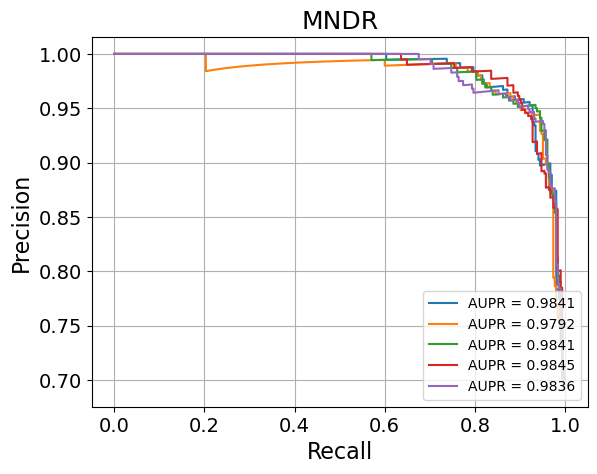

In [20]:
def main():
    # Create an argparse.Namespace object to store the arguments
    args = argparse.Namespace()

    # Manually set the values for the arguments
    args.use_sage = 'GCN'
    args.dataset = 'data2'
    args.de_v = 'v1'
    args.use_valedges_as_input = False
    args.num_layers = 4
    args.decode_layers = 2
    args.hidden_channels = 128
    args.decode_channels = 512
    args.dropout = 0.5
    args.batch_size = 64
    args.lr = 0.01
    args.epochs = 200
    args.mask_ratio = 0.2
    args.eval_steps = 1
    args.runs = 5
    args.patience = 50
    args.seed = 42

    print(args) # Adding the print statement
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)

    # ... rest of the code ...

    # device = 'cuda:0'
    # device = torch.device(device)
    # lncRNADisease MNDR
    disease_feature = pd.read_excel(
        "lncRNA\dataset\data2\MNDR-disease semantic similarity matrix.xls".format(args.dataset),
        header=0, index_col=0).values.astype(np.float32)
    lncRNA_feature = pd.read_excel(
        "lncRNA\dataset\data2\MNDR-lncRNA functional similarity matrix.xls".format(args.dataset),
        header=0, index_col=0).values.astype(np.float32)
    adj = pd.read_excel(
        "lncRNA\dataset\data2\MNDR-lncRNA-disease associations matrix.xls".format(args.dataset),
        header=0, index_col=0).values

    lncRNA_feature_padded = np.pad(lncRNA_feature, ((0, 0), (0, 256 - len(lncRNA_feature))), 'constant',
                                   constant_values=(0,))
    disease_feature_padded = np.pad(disease_feature, ((0, 0), (0, 256 - len(disease_feature))), 'constant',
                                    constant_values=(0,))
    features = np.concatenate((lncRNA_feature_padded, disease_feature_padded), axis=0)
    features_tensor = torch.tensor(features, dtype=torch.float32)

    edge_index = np.nonzero(adj)
    edge_index_tensor = torch.LongTensor(edge_index)
    edge_index_tensor[1] = edge_index_tensor[1] + len(lncRNA_feature)

    data = Data(x=features_tensor, edge_index=edge_index_tensor)

    split_edge = do_edge_split_direct(data)

    data.edge_index = to_undirected(split_edge['train']['edge'].t())
    if args.use_sage == 'GCN':
        edge_index, _ = add_self_loops(data.edge_index)
        adj = SparseTensor.from_edge_index(edge_index).t()
    else:
        edge_index = data.edge_index
        adj = SparseTensor.from_edge_index(edge_index).t()

    data = data.to(device)
    adj = adj.to(device)

    print('Start training with mask ratio={} # optimization edges={} / {}'.format(args.mask_ratio,
                                                                                  int(args.mask_ratio *
                                                                                      split_edge['train']['edge'].shape[
                                                                                          0]),
                                                                                  split_edge['train']['edge'].shape[0]))

    metric = 'AUC'
    if args.use_sage == 'SAGE':
        model = SAGE(data.num_features, args.hidden_channels,
                     args.hidden_channels, args.num_layers,
                     args.dropout).to(device)
    elif args.use_sage == 'GIN':
        model = GIN(data.num_features, args.hidden_channels,
                    args.hidden_channels, args.num_layers,
                    args.dropout).to(device)
    elif args.use_sage == 'GCN':
        model = GCN(data.num_features, args.hidden_channels,
                    args.hidden_channels, args.num_layers,
                    args.dropout).to(device)

    predictor = LPDecoder(args.hidden_channels, args.decode_channels, 1, args.num_layers,
                          args.decode_layers, args.dropout, de_v=args.de_v).to(device)

    for run in range(args.runs):
        model.reset_parameters()
        predictor.reset_parameters()
        optimizer = torch.optim.Adam(
            list(model.parameters()) + list(predictor.parameters()),
            lr=args.lr)

        best_valid = 0.0
        best_epoch = 0
        cnt_wait = 0
        for epoch in range(1, 1 + args.epochs):
            t1 = time.time()
            loss = train(model, predictor, data, split_edge, optimizer, args)
            t2 = time.time()

            results = test(model, predictor, data, adj, split_edge, args.batch_size)
            # print(results)
            valid_hits = results[metric][1]
            if valid_hits > best_valid:
                best_valid = valid_hits
                best_epoch = epoch
                cnt_wait = 0
            else:
                cnt_wait += 1

            # for key, result in results.items():
            #     train_hits, valid_hits, test_hits = result
            #     print(key)
            #     print(f'Run: {run + 1:02d} / {args.runs:02d}, '
            #           f'Epoch: {epoch:02d} / {args.epochs + 1:02d}, '
            #           f'Best_epoch: {best_epoch:02d}, '
            #           f'Best_valid: {100 * best_valid:.2f}%, '
            #           f'Loss: {loss:.4f}, '
            #           f'Train: {100 * train_hits:.2f}%, '
            #           f'Valid: {100 * valid_hits:.2f}%, '
            #           f'Test: {100 * test_hits:.2f}%',
            #           f'Time: {t2 - t1:.2f}%')
            # print('***************')
            if cnt_wait == args.patience:
            #     print('Early stopping!')
                break
        # print('##### Testing on {}/{}'.format(run, args.runs))

        results = test(model, predictor, data, adj, split_edge, args.batch_size, draw=True)
        print(results)


if __name__ == "__main__":
    main()
    plt.show()